In [ ]:
!pip install ucimlrepo numpy pandas scikit-learn tensorflow

In [ ]:
# ------- Import Dataset -------------------

from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets # unused?

# Combine Date and Time into a single DateTime column -> only 14 features
import pandas as pd
import numpy as np

X['DateTime'] = pd.to_datetime(X['Date'] + ' ' + X['Time']) # Format (JJJJ-MM-DD HH:MM:SS, e.g.: 2004-03-10 18:00:00)
X = X.set_index('DateTime')
X.drop(['Date', 'Time'], axis=1, inplace=True)  # Remove the original Date and Time columns
X.replace(-200, np.nan, inplace=True)
X.replace(-200.0, np.nan, inplace=True)

In [ ]:
pd.set_option('display.width', 1000)
print(X.head())
print(X.tail())

In [244]:
# Select only one feature
df = X[['CO(GT)']]

In [ ]:
# df = df.interpolate()
# df = df.interpolate(method='spline', order=2)

In [245]:
def custom_interpolate(row):
    if pd.isna(row['CO(GT)']):
        # Get similar instances from the data (e.g., same hour from previous days)
        similar_instances = df[(df.index.hour == row.name.hour) & ~df['CO(GT)'].isna()]
        return similar_instances['CO(GT)'].mean()
    else:
        return row['CO(GT)']

df['CO(GT)'] = df.apply(custom_interpolate, axis=1)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_21240\651421361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CO(GT)'] = df.apply(custom_interpolate, axis=1)


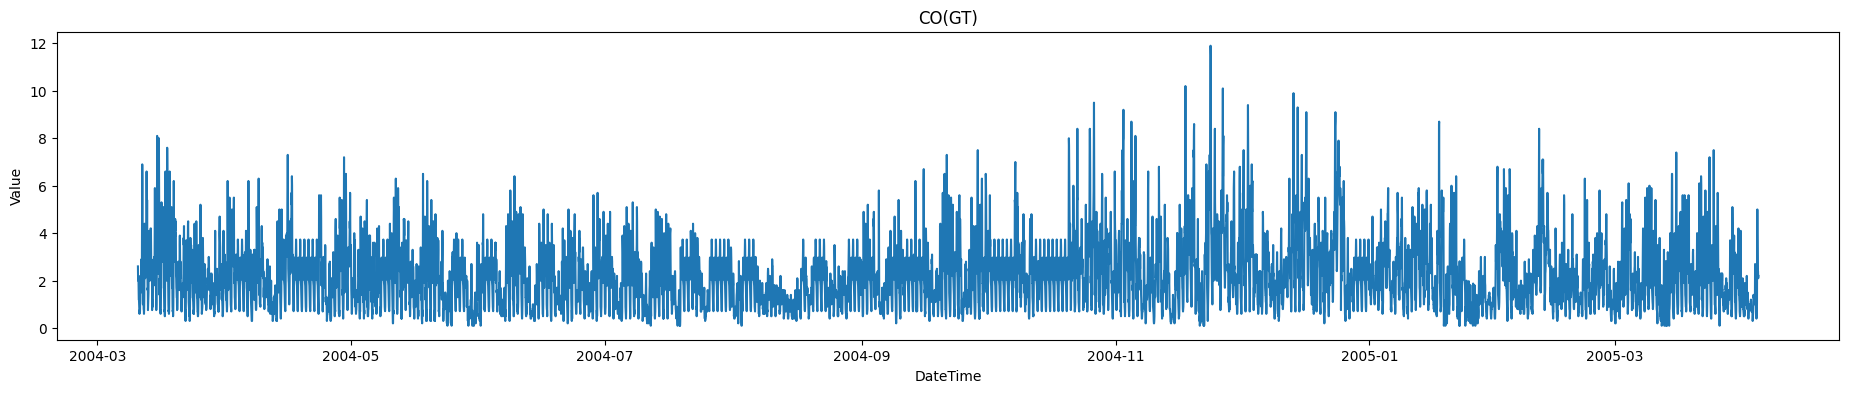

In [246]:
import matplotlib.pyplot as plt

plt.figure(figsize=(23, 4))
plt.plot(df.index, df.values)
plt.title('CO(GT)')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
data_scaled_df = pd.DataFrame(data, index=df.index, columns=df.columns)

# Plotting each feature
for feature in data_scaled_df.columns:
    plt.figure(figsize=(15, 4))
    plt.plot(data_scaled_df.index, data_scaled_df[feature], label=f'Scaled {feature}')
    plt.title(f'Scaled Data for {feature}')
    plt.xlabel('DateTime')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(23, 4))
plt.plot(df.index, df.values)
plt.title('CO(GT)')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, data, label='Scaled Data')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Scaled Time Series Data')
plt.legend()
plt.show()

In [ ]:
# LSTM data for daily (24h) seq_length
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

total_rows = len(data)
split_point = int(total_rows * 0.8)  # 80% for training, 20% for validation

train_data = data[:split_point]
validation_data = data[split_point:]

seq_length = 24 # 24h cycle
X_train, y_train = create_sequences(train_data, seq_length)
X_validate, y_validate = create_sequences(validation_data, seq_length)

In [ ]:
# LSTM data for weekly (24h*7) seq_length
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

total_rows = len(data)
split_point = int(total_rows * 0.8)  # 80% for training, 20% for validation

train_data = data[:split_point]
validation_data = data[split_point:]

seq_length = 24*7 # 24h cycle
X_train, y_train = create_sequences(train_data, seq_length)
X_validate, y_validate = create_sequences(validation_data, seq_length)

In [ ]:
# LSTM training for with seq_length from cell above (24h vs 24h*7)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model2 = Sequential()
model2.add(LSTM(70, activation='relu', input_shape=(seq_length, 1)))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='linear'))
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model2.fit(X_train, y_train, epochs=30, batch_size=32, verbose =1, validation_data=(X_validate, y_validate))

In [ ]:
# LSTM training for with seq_length from cell above (24h vs 24h*7)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose =1, validation_data=(X_validate, y_validate))

In [ ]:
#Show first and last DateTime
print(df.index[-1])
print(df.index[0])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to predict future values and store them for plotting
def predict_and_store_future_values(start_date, end_date, model, last_sequence, scaler):
    current_date = start_date
    predictions = []
    dates = []
    while current_date <= end_date:
        current_sequence = last_sequence.reshape((1, seq_length, 1))
        next_prediction = model.predict(current_sequence)[0]
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_prediction
        predictions.append(scaler.inverse_transform([next_prediction])[0][0])
        dates.append(current_date)
        current_date += timedelta(hours=1)
    return dates, predictions

# Predict for a specific future date and store the values
start_date = pd.to_datetime("2005-04-06 14:00:00") #"df.index[-1])  # Last date in your dataset 2005-04-04 14:00:00
end_date = pd.to_datetime("2005-05-08 16:00:00")
last_sequence = data[-seq_length:]  # Last known sequence from your dataset

dates, predicted_values = predict_and_store_future_values(start_date, end_date, model2, last_sequence, scaler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_values, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted Values from Last Known Date to Future Date')
plt.show()